# Directivity Measurement of Senscomp Series 7000 Transducer

This report will detail the operations done in order to characterize the radiation pattern of the transducer in object.

- Motivation: quantify the front-to-back dropoff in emission, and have a more reliable insight in the frontal hemisphere radiation pattern
- Location: Room Z72_, building Z, Universitaet Konstanz Campus
- Date: 17-18/02/2025
- Conductor(s): Gabriele Baroli, Alberto Doimo
- Instrumentation used: Neumann MA1 microphone, Behringer UMC404HD audio interface, Wuerth Laser Range Finder WDM-319, Audacity DAW


## Operations

1. The Ro-Bat and the microphone are placed in the middle of the room, 1 \[m\] apart along the longest axis. The distance is checked using the laser range finder.
   ![Measurement setup](.\IMG_20250217_173910543_HDR.jpg)

2. A python script responsible for generating short linear sweeps is launched. Each time it produces five 6\[ms\] long sweeps, from 95\[kHz\] to 10\[kHz\].

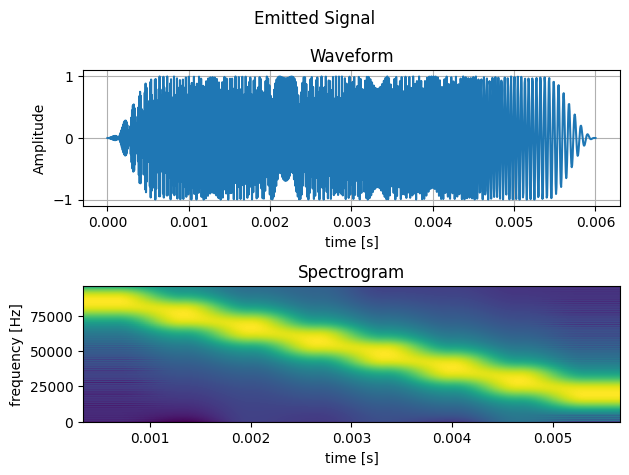

In [10]:
import numpy as np
import scipy.signal as signal
from matplotlib import pyplot as plt

def pow_two_pad_and_window(vec, show = True):
    window = signal.windows.tukey(len(vec), alpha=0.2)
    windowed_vec = vec * window
    padded_windowed_vec = np.pad(windowed_vec, (0, 2**int(np.ceil(np.log2(len(windowed_vec)))) - len(windowed_vec)))
    if show:
        dur = len(windowed_vec) / fs
        t = np.linspace(0, dur, len(windowed_vec))
        plt.figure()
        plt.suptitle('Emitted Signal')
        plt.subplot(2, 1, 1)
        plt.plot(t, windowed_vec)
        plt.grid()
        plt.title('Waveform')
        plt.xlabel('time [s]')
        plt.ylabel('Amplitude')
        plt.subplot(2, 1, 2)
        plt.specgram(windowed_vec, NFFT=256, Fs=192e3, sides='onesided')
        plt.title('Spectrogram')
        plt.xlabel('time [s]')
        plt.ylabel('frequency [Hz]')
        plt.tight_layout()
        plt.show()
    return padded_windowed_vec/max(padded_windowed_vec)

if __name__ == "__main__":

    fs = 192e3
    dur = 6e-3
    hi_freq = 95e3
    low_freq = 10e3
    n_sweeps = 5
    
    t_tone = np.linspace(0, dur, int(fs*dur))
    chirp = signal.chirp(t_tone, hi_freq, t_tone[-1], low_freq)
    sig = pow_two_pad_and_window(chirp, show=True)

3. The sweeps are recorded with Audacity through the mic and sound card listed above.

4. The Ro-Bat is rotated 10 \[deg\] counterclockwise, with the help of a goniometer printed on a sheet of paper and placed underneath, and steps 1-3 are repeated until the Ro-Bat is rotated 180 \[deg\] with respect to its starting position
![Ro-Bat and goniometer from above](.\IMG_20250217_173919680.jpg)

## Processing
1. The recordings are high-pass filtered up to 4000 \[Hz\], in order to cancel the strong DC-bias present in the microphone, then exported to separate wav files.
2. Each recording is time gated around one of the sweeps, since the first reflections don't overlap with the emitted signal.

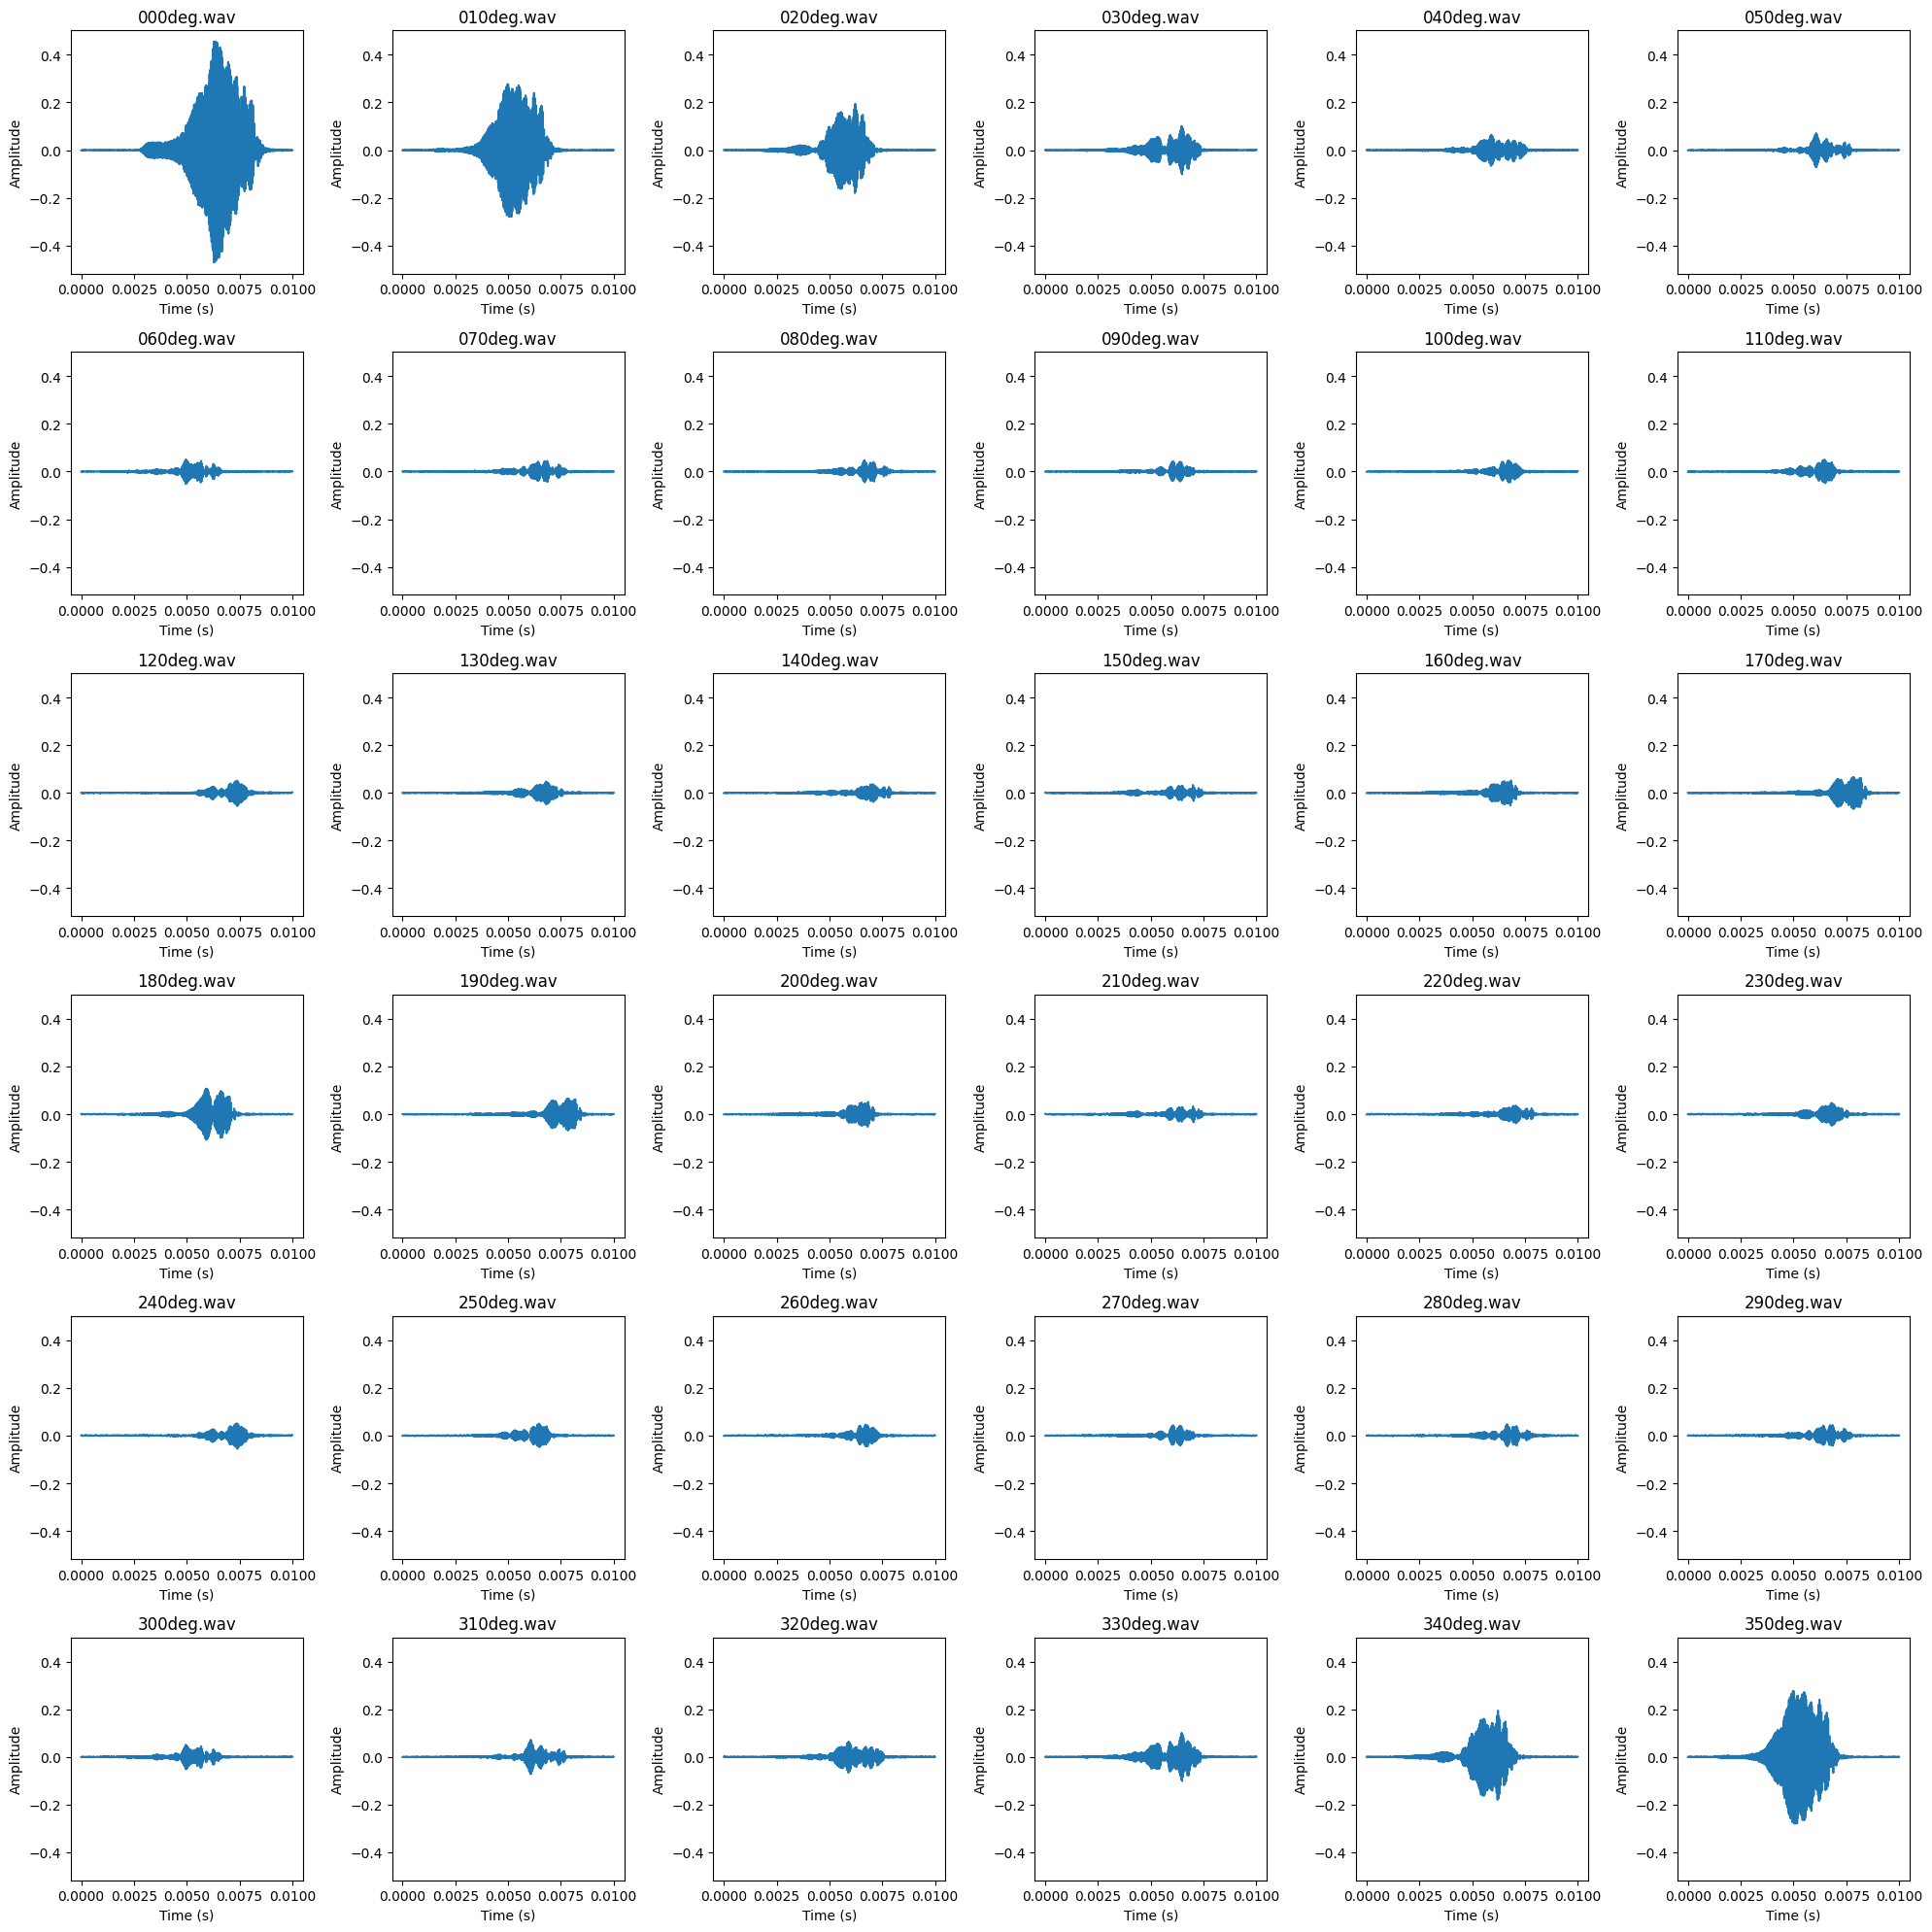

In [22]:
import os
import soundfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

# Load audio files, then plot them in a 6x6 grid
DIR = "../RoBat-Garage/senscomp7000 directivity/cut_sweeps/"  # Directory containing the audio files
audio_files = os.listdir(DIR)  # List all files in the sweeps directory

# %% Plot of the collected data

fig, axs = plt.subplots(6, 6, figsize=(20, 20))

for i in range(6):
    for j in range(6):
        # Load audio file
        audio, fs = soundfile.read(DIR + audio_files[i * 6 + j])
        # Plot audio file
        axs[i, j].plot(np.linspace(0, len(audio) / fs, len(audio)), audio)
        axs[i, j].set_title(audio_files[i * 6 + j])
        axs[i, j].set_xlabel("Time (s)")
        axs[i, j].set_ylabel("Amplitude")
        # Shared x and y axes
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])

plt.tight_layout()
plt.show()

3. From the isolated sweeps, the directivity pattern is computed, both for the whole spectrum of emission, and in bands. A symmetric approach is adopted, due to the geometry of the transducer.

Text(0.5, 1.0, 'Senscomp Series 7000 Transducer Mean Radiance Pattern 10[kHz] - 95[kHz]')

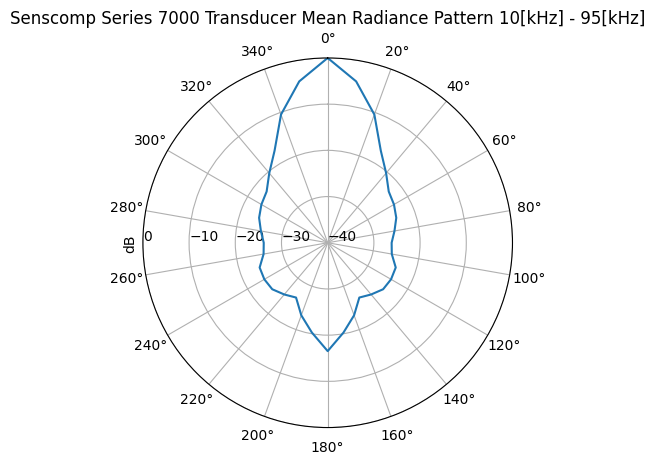

In [25]:
# %% Radiance computation

channels = []
for i in np.arange(len(audio_files)):
    audio, fs = soundfile.read(DIR + audio_files[i])
    if audio.shape[0] > 1919:
        audio = audio[0:1919]
    channels.append(audio)
channels = np.array(channels)

Channels = fft.fft(channels, n=2048, axis=1)
Channels_uni = Channels[:, 0:1024]
freqs = fft.fftfreq(2048, 1 / fs)
freqs = freqs[0:1024]
R = 1
radiance = 4 * np.pi * R * np.abs(Channels_uni)
theta = np.linspace(0, 350, 36)
theta = np.append(theta, theta[0])

# %% Mean radiance pattern display

rad_patt = np.mean(radiance, axis=1)
rad_patt_norm = rad_patt / np.max(rad_patt)
rad_patt_norm_dB = 20 * np.log10(rad_patt_norm)
rad_patt_norm_dB = np.append(rad_patt_norm_dB, rad_patt_norm_dB[0])

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(np.deg2rad(theta), rad_patt_norm_dB)
# offset polar axes by -90 degrees
ax.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax.set_theta_direction(-1)
# more theta ticks
ax.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
ax.set_ylabel("dB")
# less radial ticks
ax.set_yticks(np.linspace(-40, 0, 5))
ax.set_rlabel_position(-90)
ax.set_title(
    "Senscomp Series 7000 Transducer Mean Radiance Pattern 10[kHz] - 95[kHz]"
)

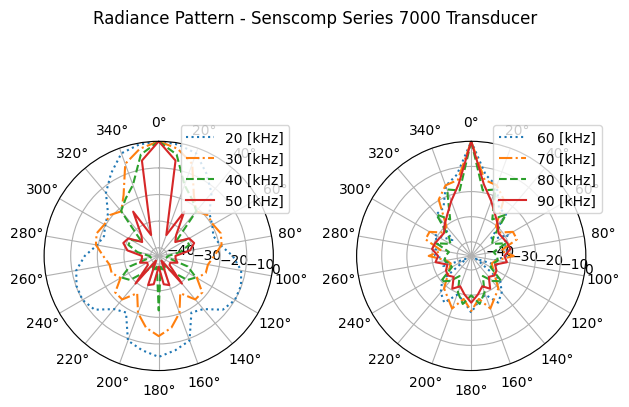

In [27]:
central_freq = np.array([20e3, 30e3, 40e3, 50e3, 60e3, 70e3, 80e3, 90e3])
BW = 2e3

linestyles = ["-", "--", "-.", ":"]

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "polar"})
plt.suptitle("Radiance Pattern - Senscomp Series 7000 Transducer")
i = 3
for fc in central_freq[0:4]:
    rad_patt = np.mean(
        radiance[:, (freqs < fc + BW) & (freqs > fc - BW)], axis=1
    )
    rad_patt_norm = rad_patt / np.max(rad_patt)
    rad_patt_norm_dB = 20 * np.log10(rad_patt_norm)
    rad_patt_norm_dB = np.append(rad_patt_norm_dB, rad_patt_norm_dB[0])
    ax1.plot(
        np.deg2rad(theta),
        rad_patt_norm_dB,
        label=str(fc)[0:2] + " [kHz]",
        linestyle=linestyles[i],
    )
    i -= 1
ax1.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
# offset polar axes by -90 degrees
ax1.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax1.set_theta_direction(-1)
# more theta ticks
ax1.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
# less radial ticks
ax1.set_yticks(np.linspace(-40, 0, 5))
ax1.set_rlabel_position(100)

i = 3
for fc in central_freq[4:8]:
    rad_patt = np.mean(
        radiance[:, (freqs < fc + BW) & (freqs > fc - BW)], axis=1
    )
    rad_patt_norm = rad_patt / np.max(rad_patt)
    rad_patt_norm_dB = 20 * np.log10(rad_patt_norm)
    rad_patt_norm_dB = np.append(rad_patt_norm_dB, rad_patt_norm_dB[0])
    ax2.plot(
        np.deg2rad(theta),
        rad_patt_norm_dB,
        label=str(fc)[0:2] + " [kHz]",
        linestyle=linestyles[i],
    )
    i -= 1
ax2.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
# offset polar axes by -90 degrees
ax2.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax2.set_theta_direction(-1)
# more theta ticks
ax2.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
# less radial ticks
ax2.set_yticks(np.linspace(-40, 0, 5))
ax2.set_rlabel_position(100)

plt.tight_layout()
plt.show()

## Conclusions
- The results confirm the information present in the datasheet: the two patterns at 50\[kHz\] do have a certain degree of similarity.
- Regarding the whole signal, there is a dropoff of about -17 \[dB\] front-to-back, which is acceptable with respect to actual bat emissions.
- Unsurprisingly, the main lobe gets narrower as the frequency of emission is greater.


## Data
- SNR of the recordings: 

In [16]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('./SNR.csv')

# Convert the DataFrame to a markdown table
markdown_table = df.to_markdown(index=False)

# Print the markdown table
print(markdown_table)

|   Angle [deg] |   SNR [dB RMS] |
|--------------:|---------------:|
|             0 |          44.71 |
|            10 |          39.16 |
|            20 |          34.82 |
|            30 |          28.53 |
|            40 |          24.33 |
|            50 |          23.52 |
|            60 |          22.04 |
|            70 |          21.25 |
|            80 |          20.44 |
|            90 |          19.18 |
|           100 |          21.41 |
|           110 |          22.45 |
|           120 |          22.41 |
|           130 |          22.57 |
|           140 |          19.59 |
|           150 |          20.01 |
|           160 |          21.96 |
|           170 |          27.01 |
|           180 |          29.81 |


- Datasheet radiance pattern of the transducer:
  
![data sheet radiance](.\data_sheet_radiance.png)

## Notes
- Some milliseconds of silence (zeros) are needed after the signal in order not to cut prematurely the emission.